# Stock Price Prediction of ADBL

## Import the Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from keras import Sequential
from keras.layers import GRU, LSTM, SimpleRNN,  Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2022-07-30 04:57:34.192669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-30 04:57:34.192711: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [3]:
adbl_df = pd.read_csv("data/ADBL.csv")
adbl_df.shape

(2572, 8)

In [4]:
adbl_df.head()

,S.N.,Date,Total Transactions,Total Traded Shares,Total Traded Amount,Max. Price,Min. Price,Close Price
0,1,2021-12-29,1013,200533.0,98526860.8,499.0,488.0,492.0
1,2,2021-12-28,659,91046.0,44737396.5,498.0,488.0,494.0
2,3,2021-12-27,816,88858.0,44186856.3,510.0,491.0,493.0
3,4,2021-12-26,1002,130801.0,65306688.9,502.0,495.0,500.0
4,5,2021-12-23,714,77234.0,38044401.2,497.0,481.0,496.0


## Renaming the Columns 

In [5]:
adbl_df.columns = ['SN', 'Date', 'TTrans', 'TTS','TTA', 'MaxPrice', 'MinPrice', 'ClosePrice']

In [6]:
adbl_df.head()

,SN,Date,TTrans,TTS,TTA,MaxPrice,MinPrice,ClosePrice
0,1,2021-12-29,1013,200533.0,98526860.8,499.0,488.0,492.0
1,2,2021-12-28,659,91046.0,44737396.5,498.0,488.0,494.0
2,3,2021-12-27,816,88858.0,44186856.3,510.0,491.0,493.0
3,4,2021-12-26,1002,130801.0,65306688.9,502.0,495.0,500.0
4,5,2021-12-23,714,77234.0,38044401.2,497.0,481.0,496.0


In [7]:
adbl_df.shape

(2572, 8)

Converting the Date into Panda's Date Time 

In [8]:
adbl_df['Date'] = pd.to_datetime(adbl_df['Date'])

## Sorting the Date by Date in Ascending Order

In [9]:
adbl_df=adbl_df.sort_values(by='Date')

## Setting Features and Target Column

In [10]:
features = ['Date','ClosePrice']

In [11]:
X = adbl_df[features]

In [12]:
X.set_index("Date",inplace=True)

## Splitting the Data Into Training, Validation and Test Set

In [13]:
X_train_split, X_test_split = train_test_split(X, train_size=0.8,shuffle=False)
X_test_split, X_valid_split = train_test_split(X_test_split, train_size=0.5,shuffle=False)

## Fucntion to slice data to Predict next day’s closing price by looking into previous 5 day’s data

In [14]:
def SliceData(data,step):     
    X,Y = [],[]
    for i in range(len(data)-step):
        X.append(data[i:(i+step),])
        Y.append(data[(i+step),])
    return np.array(X),np.array(Y)

## Normalizing the Data Using Standard Scalar

In [15]:
std_scalar = StandardScaler()
X_train = std_scalar.fit_transform(X_train_split)
X_valid = std_scalar.fit_transform(X_valid_split)
X_test = std_scalar.fit_transform(X_test_split)

## Getting the Sliced Data

In [16]:
steps = 5
X_train,y_train = SliceData(X_train,steps)
X_test,y_test = SliceData(X_test,steps)
X_valid,y_valid = SliceData(X_valid,steps)

## Building the RNN Model

In [17]:
RNN_Model = Sequential()
RNN_Model.add(SimpleRNN(50,input_shape=(steps,1),return_sequences=True ))
RNN_Model.add(Dropout(0.5))
RNN_Model.add(SimpleRNN(50))
RNN_Model.add(Dropout(0.5))
RNN_Model.add(Dense(50))
RNN_Model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])

2022-07-30 04:57:36.425982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-30 04:57:36.426040: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-30 04:57:36.426075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xenon-Inspiron-3442): /proc/driver/nvidia/version does not exist
2022-07-30 04:57:36.426481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
RNN_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 50)             2600      
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
Total params: 10,200
Trainable params: 10,200
Non-trainable params: 0
_________________________________________________________________


## Building LSTM Model

In [19]:
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(50,input_shape=(steps,1),return_sequences=True ))
LSTM_Model.add(Dropout(0.5))
LSTM_Model.add(LSTM(50))
LSTM_Model.add(Dropout(0.5))
LSTM_Model.add(Dense(50))
LSTM_Model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])

In [20]:
LSTM_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
Total params: 33,150
Trainable params: 33,150
Non-trainable params: 0
_________________________________________________________________


## Fitting the RNN Model

In [21]:
RNN_History = RNN_Model.fit(X_train,y_train,epochs=100,batch_size = 50,validation_data=(X_valid,y_valid),shuffle=False, 
                    verbose = 2)

Epoch 1/100
42/42 - 2s - loss: 0.8075 - mae: 0.6293 - val_loss: 0.2648 - val_mae: 0.3807 - 2s/epoch - 49ms/step
Epoch 2/100
42/42 - 0s - loss: 0.4086 - mae: 0.4325 - val_loss: 0.1636 - val_mae: 0.3003 - 275ms/epoch - 7ms/step
Epoch 3/100
42/42 - 0s - loss: 0.2826 - mae: 0.3585 - val_loss: 0.1417 - val_mae: 0.2838 - 247ms/epoch - 6ms/step
Epoch 4/100
42/42 - 0s - loss: 0.2341 - mae: 0.3232 - val_loss: 0.1184 - val_mae: 0.2571 - 288ms/epoch - 7ms/step
Epoch 5/100
42/42 - 0s - loss: 0.1906 - mae: 0.2914 - val_loss: 0.0920 - val_mae: 0.2185 - 343ms/epoch - 8ms/step
Epoch 6/100
42/42 - 0s - loss: 0.1630 - mae: 0.2732 - val_loss: 0.0820 - val_mae: 0.2068 - 238ms/epoch - 6ms/step
Epoch 7/100
42/42 - 0s - loss: 0.1471 - mae: 0.2570 - val_loss: 0.0833 - val_mae: 0.2143 - 254ms/epoch - 6ms/step
Epoch 8/100
42/42 - 0s - loss: 0.1337 - mae: 0.2469 - val_loss: 0.0871 - val_mae: 0.2238 - 273ms/epoch - 6ms/step
Epoch 9/100
42/42 - 0s - loss: 0.1184 - mae: 0.2373 - val_loss: 0.0848 - val_mae: 0.2230 -

Epoch 73/100
42/42 - 0s - loss: 0.0541 - mae: 0.1517 - val_loss: 0.1002 - val_mae: 0.2526 - 217ms/epoch - 5ms/step
Epoch 74/100
42/42 - 0s - loss: 0.0577 - mae: 0.1570 - val_loss: 0.0695 - val_mae: 0.1979 - 380ms/epoch - 9ms/step
Epoch 75/100
42/42 - 0s - loss: 0.0459 - mae: 0.1369 - val_loss: 0.0626 - val_mae: 0.1862 - 269ms/epoch - 6ms/step
Epoch 76/100
42/42 - 0s - loss: 0.0442 - mae: 0.1351 - val_loss: 0.0609 - val_mae: 0.1798 - 220ms/epoch - 5ms/step
Epoch 77/100
42/42 - 0s - loss: 0.0407 - mae: 0.1303 - val_loss: 0.0485 - val_mae: 0.1497 - 271ms/epoch - 6ms/step
Epoch 78/100
42/42 - 0s - loss: 0.0457 - mae: 0.1329 - val_loss: 0.0734 - val_mae: 0.2065 - 254ms/epoch - 6ms/step
Epoch 79/100
42/42 - 0s - loss: 0.0471 - mae: 0.1400 - val_loss: 0.0607 - val_mae: 0.1818 - 215ms/epoch - 5ms/step
Epoch 80/100
42/42 - 0s - loss: 0.0439 - mae: 0.1340 - val_loss: 0.0906 - val_mae: 0.2352 - 210ms/epoch - 5ms/step
Epoch 81/100
42/42 - 0s - loss: 0.0530 - mae: 0.1511 - val_loss: 0.1466 - val_ma

In [22]:
LSTM_History = LSTM_Model.fit(X_train,y_train,epochs=100,batch_size = 50,validation_data=(X_valid,y_valid),shuffle=False, 
                    verbose = 2)

Epoch 1/100
42/42 - 5s - loss: 0.8692 - mae: 0.7307 - val_loss: 0.4351 - val_mae: 0.5097 - 5s/epoch - 125ms/step
Epoch 2/100
42/42 - 0s - loss: 0.3558 - mae: 0.3989 - val_loss: 0.2074 - val_mae: 0.3397 - 372ms/epoch - 9ms/step
Epoch 3/100
42/42 - 0s - loss: 0.1888 - mae: 0.2754 - val_loss: 0.1902 - val_mae: 0.3285 - 371ms/epoch - 9ms/step
Epoch 4/100
42/42 - 0s - loss: 0.1625 - mae: 0.2759 - val_loss: 0.2000 - val_mae: 0.3343 - 371ms/epoch - 9ms/step
Epoch 5/100
42/42 - 0s - loss: 0.1468 - mae: 0.2659 - val_loss: 0.1914 - val_mae: 0.3263 - 370ms/epoch - 9ms/step
Epoch 6/100
42/42 - 0s - loss: 0.1317 - mae: 0.2495 - val_loss: 0.1763 - val_mae: 0.3101 - 378ms/epoch - 9ms/step
Epoch 7/100
42/42 - 0s - loss: 0.1140 - mae: 0.2321 - val_loss: 0.1614 - val_mae: 0.2922 - 368ms/epoch - 9ms/step
Epoch 8/100
42/42 - 0s - loss: 0.1004 - mae: 0.2158 - val_loss: 0.1525 - val_mae: 0.2817 - 431ms/epoch - 10ms/step
Epoch 9/100
42/42 - 0s - loss: 0.0891 - mae: 0.2035 - val_loss: 0.1404 - val_mae: 0.2659

Epoch 73/100
42/42 - 0s - loss: 0.0447 - mae: 0.1414 - val_loss: 0.1029 - val_mae: 0.2294 - 351ms/epoch - 8ms/step
Epoch 74/100
42/42 - 0s - loss: 0.0415 - mae: 0.1263 - val_loss: 0.0907 - val_mae: 0.2125 - 351ms/epoch - 8ms/step
Epoch 75/100
42/42 - 0s - loss: 0.0432 - mae: 0.1335 - val_loss: 0.0966 - val_mae: 0.2257 - 357ms/epoch - 9ms/step
Epoch 76/100
42/42 - 0s - loss: 0.0396 - mae: 0.1320 - val_loss: 0.0901 - val_mae: 0.2151 - 374ms/epoch - 9ms/step
Epoch 77/100
42/42 - 0s - loss: 0.0412 - mae: 0.1271 - val_loss: 0.0874 - val_mae: 0.2073 - 362ms/epoch - 9ms/step
Epoch 78/100
42/42 - 0s - loss: 0.0379 - mae: 0.1265 - val_loss: 0.1397 - val_mae: 0.2742 - 350ms/epoch - 8ms/step
Epoch 79/100
42/42 - 0s - loss: 0.0470 - mae: 0.1407 - val_loss: 0.1000 - val_mae: 0.2359 - 363ms/epoch - 9ms/step
Epoch 80/100
42/42 - 0s - loss: 0.0485 - mae: 0.1459 - val_loss: 0.1013 - val_mae: 0.2347 - 349ms/epoch - 8ms/step
Epoch 81/100
42/42 - 1s - loss: 0.0420 - mae: 0.1383 - val_loss: 0.1186 - val_ma

## Make Predictions

In [23]:
RNN_Predictions = RNN_Model.predict(X_test)
LSTM_predictions = LSTM_Model.predict(X_test)

## Inverse Transform the Values

In [24]:
RNN_act_prd = std_scalar.inverse_transform(RNN_Predictions)
LSTM_act_prd = std_scalar.inverse_transform(LSTM_predictions)

## Evalation Metrics (RMSE and MAE)

In [25]:
print("### RNN Model ###")
Y_test_res_RNN = std_scalar.inverse_transform(y_test)
pre_RNN = RNN_act_prd[:,:1]

rmse=np.sqrt(np.mean(((pre_RNN- Y_test_res_RNN)**2)))
print(f"RMSE {rmse}"  )

print(f"MAE {mean_absolute_error(Y_test_res_RNN, pre_RNN)}")

### RNN Model ###
RMSE 9.715363292220541
MAE 6.335043649824839


In [26]:
print("### LSTM Model ###")
Y_test_res_LSTM = std_scalar.inverse_transform(y_test)
pre_LSTM = LSTM_act_prd[:,:1]

rmse=np.sqrt(np.mean(((pre_LSTM- Y_test_res_LSTM)**2)))
print(f"RMSE {rmse}"  )

print(f"MAE {mean_absolute_error(Y_test_res_LSTM, pre_LSTM)}")

### LSTM Model ###
RMSE 11.515386909556055
MAE 7.437573387509301


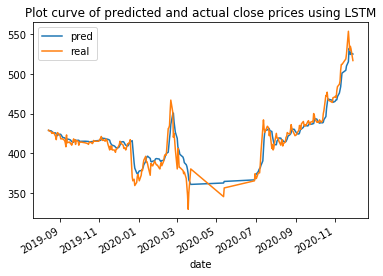

In [27]:
plot =pd.DataFrame()
plot["pred"]=list(map(float, pre_LSTM))
plot["real"]=list(map(float, Y_test_res_LSTM))
plot["date"]=X_test_split.index[:-steps]
plot.plot(kind="line", x="date", title="Plot curve of predicted and actual close prices using LSTM")
plt.show()

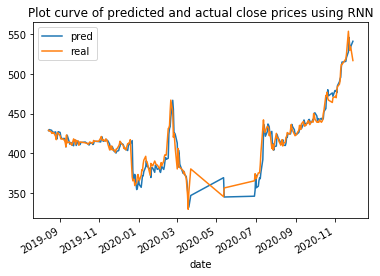

In [28]:
plot =pd.DataFrame()
plot["pred"]=list(map(float, pre_RNN))
plot["real"]=list(map(float, Y_test_res_RNN))
plot["date"]=X_test_split.index[:-steps]
plot.plot(kind="line", x="date", title="Plot curve of predicted and actual close prices using RNN")
plt.show()

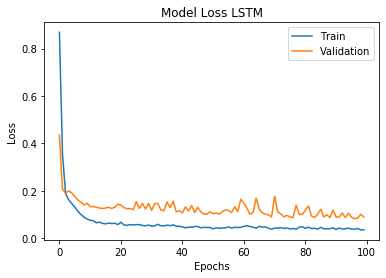

In [29]:
plt.plot(LSTM_History.history['loss'])
plt.plot(LSTM_History.history['val_loss'])
plt.title('Model Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

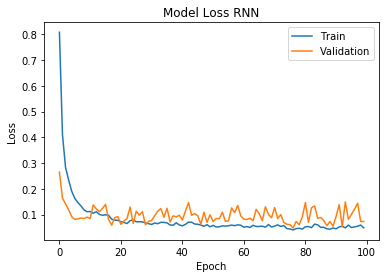

In [30]:
plt.plot(RNN_History.history['loss'])
plt.plot(RNN_History.history['val_loss'])
plt.title('Model Loss RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

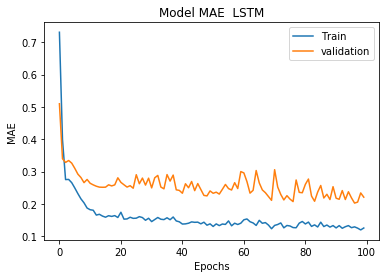

In [31]:
plt.plot(LSTM_History.history['mae'])
plt.plot(LSTM_History.history['val_mae'])
plt.title('Model MAE  LSTM')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

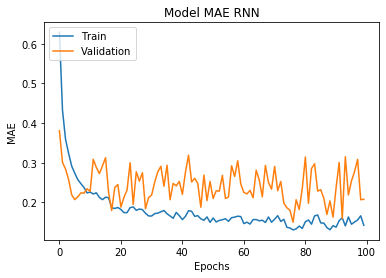

In [32]:
plt.plot(RNN_History.history['mae'])
plt.plot(RNN_History.history['val_mae'])
plt.title('Model MAE RNN')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Conclusion

1. For ADBL Bank LSTM and RNN Models used for Stock Price Prediction
2. The Error is Low for RNN Model